# Phylogenetic Distance Calculation from RhizCG 2013

Notes: Calculate phylogenetic distance using phylogeny created from rbcL and matK in phylogenerator 20160209_phylogeny.tre.  

# Init

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(foreach)
library(lsmeans)
library(Hmisc)
library(lme4)
library(lmerTest)
library(ggplot2)
library(plyr)
library(dplyr)
library(tidyr)
library(pbkrtest)
library(gridExtra)
library(reshape2)
library(picante)
library(ape)
library(phyloseq)
library(doParallel)


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: foreach: simple, scalable parallel programming from Revolution Analytics
Use Revolution R for scalability, fault tolerance and more.
http://www.revolutionanalytics.com

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: estimability

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: lattice

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: survival

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: For

In [3]:
%%R
# Initialize corMLPE 
source('/home/bryan/corMLPE/corMLPE.R')

## Set file locations

In [4]:
%%R
workDir = '/home/bryan/RhizCG/PhyDist/'
treeFile = '/home/bryan/RhizCG/PhyDist/20160209_phylogeny.tre'
NAMFile = '/home/bryan/RhizCG/PhyDist/NAM_founders_distanceMatrix_v2.txt'

### Read  tables table 

In [5]:
%%R
setwd(workDir)
# read phylogenetic distance, expanded with 0.0002 between maize
phy_expand = read.csv(file = "phyDist_expanded.csv", header = TRUE)
colnames(phy_expand)[12] = "75-062"

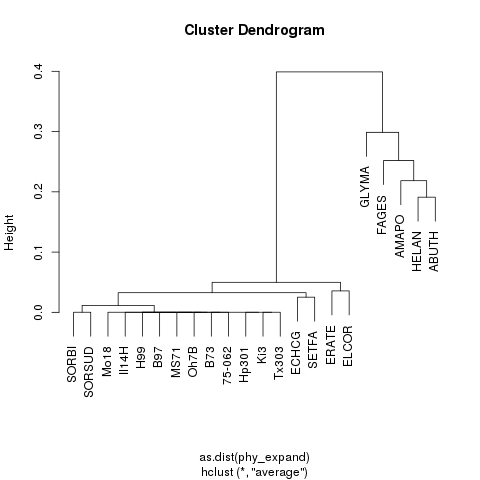

In [6]:
%%R
Phy_hc = hclust(as.dist(phy_expand), "average")
plot(Phy_hc)

In [101]:
%%R
#Read rarified phyloseq object
F = file.path('/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/physeq/Full-Sparsity3in3_r')
physeq.Full = readRDS(F)

physeq.Nneg = subset_samples(physeq.Full, Treatment == "Nneg" & Plant != "BARE")
physeq.Nneg = filter_taxa(physeq.Nneg, function(x) sum(x > 0) > 0, TRUE)  
physeq.Nneg
    
    
# trim with log2fold change file  
log2foldFile = '/home/bryan/RhizCG/data/MiSeq_amplicon/MergedRuns/DeSeq2/bare-plant.csv'
l2f = read.csv(log2foldFile, header = TRUE) 
l2f = l2f[l2f$p.adj < .05,]
resp = l2f$OTU %>% unique %>% as.character
l2f = NULL

phy = prune_taxa(resp, physeq.Nneg)
phy = subset_samples(phy, Plant != "BARE")
phy

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1505 taxa and 87 samples ]
sample_data() Sample Data:       [ 87 samples by 55 sample variables ]
tax_table()   Taxonomy Table:    [ 1505 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1505 tips and 1504 internal nodes ]


## Define subset of plants for model comparison

In [148]:
%%R
phy = subset_samples(phy, Type != "Maize" | Plant == "Il14H" | Plant == "Ki3")

phy

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 1505 taxa and 43 samples ]
sample_data() Sample Data:       [ 43 samples by 60 sample variables ]
tax_table()   Taxonomy Table:    [ 1505 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 1505 tips and 1504 internal nodes ]


## Calculate w-Unifrac distances

In [149]:
%%R
registerDoParallel(cores=28)
phy.wunif.dist = distance(phy, 
                      method = "unifrac", 
                      weighted = TRUE,
                      fast = TRUE, 
                      parallel = TRUE, 
                      normalized = FALSE)


# Data wrangling 

## Create melted dataframes for plot by plot comparisons

In [150]:
%%R
pd.m = melt(as.matrix(phy_expand))

#set column names and create comparison column
colnames(pd.m) = c("PlantA", "PlantB", "phy_Dist")
pd.m$PlantComp = paste(pd.m$PlantA, pd.m$PlantB, sep = "-")
pd.m %>% head


  PlantA PlantB phy_Dist   PlantComp
1  FAGES  FAGES  0.00000 FAGES-FAGES
2  AMAPO  FAGES  0.23210 AMAPO-FAGES
3  HELAN  FAGES  0.25302 HELAN-FAGES
4  ABUTH  FAGES  0.27096 ABUTH-FAGES
5  GLYMA  FAGES  0.35879 GLYMA-FAGES
6  SORBI  FAGES  0.43476 SORBI-FAGES


In [151]:
%%R
ud = as.matrix(phy.wunif.dist) 
# remove lower triangle to remove duplicate values
ud[ lower.tri( ud, diag = TRUE ) ]  <- NA
head(ud)
ud.m = melt(ud, na.rm= TRUE)
colnames(ud.m) = c("PlotA", "PlotB", "w_Unif_Dist")
head(ud.m) %>% print
dim(ud.m) %>% print

                PlotA             PlotB w_Unif_Dist
44  sample4-2.02_Nneg sample4-4.21_Nneg   0.2424328
87  sample4-2.02_Nneg sample1-2.23_Nneg   0.3144329
88  sample4-4.21_Nneg sample1-2.23_Nneg   0.2545934
130 sample4-2.02_Nneg sample2-2.08_Nneg   0.2000060
131 sample4-4.21_Nneg sample2-2.08_Nneg   0.2237384
132 sample1-2.23_Nneg sample2-2.08_Nneg   0.2822632
[1] 903   3


## Create functional distance variable (with residuals)

In [152]:
%%R
#add growing degree days
DAP = c(36, 53, 57, 61, 72, 79, 84, 88)
GDD = c(795.1, 1089.4, 1136.8, 1199.5, 1394.3, 1512.4, 1573.8, 1625.6)
M_GDD = cbind(DAP, GDD) %>% as.data.frame
M_GDD

Plant = c("ERATE", "HELAN", "B73", "FAGES", "AMAPO", "SORSUD", "SORBI", 
          "ELCOR", "ECHCG", "ABUTH", "SETFA", "GLYMA", "MS71", "Mo18", "Il14H", "Tx303", "Oh7B",
         "B97", "Hp301", "75-062", "Ki3", "H99")
SeedSize_mg = c(.0035, 90, 333, 38, .49, 10.7, 32.39,
               3.2, 1.58, 9.6, 1.8, 174, .264, .224, 0.219, 0.279, 0.207,
               0.240, 0.0869, 0.222, 0.228, 0.231)
SS = cbind(Plant, SeedSize_mg) %>% as.data.frame
head(SS) %>% print
SS$SeedSize_mg = SS$SeedSize_mg %>% as.character %>% as.numeric
(SS)

   Plant SeedSize_mg
1  ERATE      0.0035
2  HELAN          90
3    B73         333
4  FAGES          38
5  AMAPO        0.49
6 SORSUD        10.7
    Plant SeedSize_mg
1   ERATE      0.0035
2   HELAN     90.0000
3     B73    333.0000
4   FAGES     38.0000
5   AMAPO      0.4900
6  SORSUD     10.7000
7   SORBI     32.3900
8   ELCOR      3.2000
9   ECHCG      1.5800
10  ABUTH      9.6000
11  SETFA      1.8000
12  GLYMA    174.0000
13   MS71      0.2640
14   Mo18      0.2240
15  Il14H      0.2190
16  Tx303      0.2790
17   Oh7B      0.2070
18    B97      0.2400
19  Hp301      0.0869
20 75-062      0.2220
21    Ki3      0.2280
22    H99      0.2310


In [153]:
%%R
# PCA of annuals
sd = as(sample_data(phy), "data.frame")
sd$Plant %>% levels %>% print
sd = left_join(sd, SS, by = "Plant")
sd = left_join(sd, M_GDD, by = "DAP")

 fit = prcomp(~log(SeedSize_mg) + A_Resid_logN + A_Resid_logCN + A_Resid_logB, data = sd, 
                 na.action = na.exclude, center = TRUE, scale = TRUE)

summary(fit) %>% print
fit$rotation %>% print
biplot(fit)

NULL
Error in model.frame.default(formula = ~log(SeedSize_mg) + A_Resid_logN +  : 
  variable lengths differ (found for 'A_Resid_logN')


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in model.frame.default(formula = ~log(SeedSize_mg) + A_Resid_logN +  : 
  variable lengths differ (found for 'A_Resid_logN')

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: There were 22 warnings (use warnings() to see them)
  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [154]:
%%R -w 600 -h 500
S = predict(fit)[,1:3]
E_Fit = cbind(sd, S)
row.names(E_Fit) = E_Fit$X.sample
sample_data(phy) = E_Fit


p = ggplot(E_Fit, aes(PC1, PC3, colour = Plant, 
                       size = A_Resid_logN), pch = 21)
p = p + geom_point()
#p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of Growth Residuals")
p


Error in data.frame(..., check.names = FALSE) : 
  arguments imply differing number of rows: 43, 47


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in data.frame(..., check.names = FALSE) : 
  arguments imply differing number of rows: 43, 47

  res = super(Function, self).__call__(*new_args, **new_kwargs)


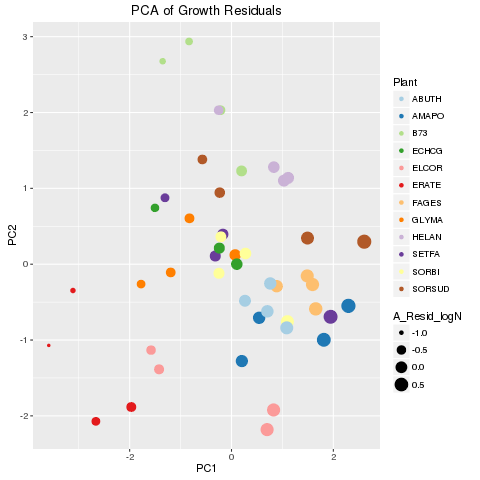

In [155]:
%%R
p = ggplot(E_Fit, aes(PC1, PC2, colour = Plant, 
                       size = A_Resid_logN), pch = 21)
p = p + geom_point()
p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of Growth Residuals")
p

In [156]:
%%R
#measure distances on PC1
sd = sample_data(phy)
PC1dist = dist(sd[, "PC1"], method = "euclidian")
    #melt matrix
    PC1.m = melt(as.matrix(PC1dist))

    #set column names and create comparison column
     colnames(PC1.m) = c("PlotA", "PlotB", "PC1Dist")
    PC1.m$PlotComp = paste(PC1.m$PlotA, PC1.m$PlotB, sep = "-")
    PC1.m %>% head

#measure distances on PC2
PC2dist = dist(sd[,"PC2"], method = "euclidian")
    #melt matrix
    PC2.m = melt(as.matrix(PC2dist))

    #set column names and create comparison column
     colnames(PC2.m) = c("PlotA", "PlotB", "PC2Dist")
    PC2.m$PlotComp = paste(PC2.m$PlotA, PC2.m$PlotB, sep = "-")
    PC2.m %>% head

#measure distances on PC3
PC3dist = dist(sd[,"PC3"], method = "euclidian")
    #melt matrix
    PC3.m = melt(as.matrix(PC3dist))

    #set column names and create comparison column
     colnames(PC3.m) = c("PlotA", "PlotB", "PC3Dist")
    PC3.m$PlotComp = paste(PC3.m$PlotA, PC3.m$PlotB, sep = "-")
    PC3.m %>% head %>% print

#measure distances on residCN
CNdist = dist(sd[,"A_Resid_logCN"], method = "euclidian")
    #melt matrix
    CN.m = melt(as.matrix(CNdist))

    #set column names and create comparison column
     colnames(CN.m) = c("PlotA", "PlotB", "CNdist")
    CN.m$PlotComp = paste(CN.m$PlotA, CN.m$PlotB, sep = "-")
    CN.m %>% head %>% print

#measure distances on residBiomass
Bdist = dist(sd[,"A_Resid_logB"], method = "euclidian")
    #melt matrix
    B.m = melt(as.matrix(Bdist))

    #set column names and create comparison column
     colnames(B.m) = c("PlotA", "PlotB", "Bdist")
    B.m$PlotComp = paste(B.m$PlotA, B.m$PlotB, sep = "-")
    B.m %>% head %>% print

Fundist = dist(sd[,c("PC1", "PC2", "PC3")], method = "euclidian")
    Fun.m = melt(as.matrix(Fundist))

    #set column names and create comparison column
     colnames(Fun.m) = c("PlotA", "PlotB", "FunDist")
    Fun.m$PlotComp = paste(Fun.m$PlotA, PC3.m$PlotB, sep = "-")
    Fun.m %>% head %>% print
PCA.m = left_join(PC1.m, PC2.m[,c(3,4)], by = "PlotComp")
PCA.m = left_join(PCA.m, PC3.m[,c(3,4)], by = "PlotComp")
PCA.m = left_join(PCA.m, Fun.m[,c(3,4)], by = "PlotComp")
PCA.m = left_join(PCA.m, CN.m[,c(3,4)], by = "PlotComp")
PCA.m = left_join(PCA.m, B.m[,c(3,4)], by = "PlotComp")
head(PCA.m)

              PlotA             PlotB   PC3Dist
1 sample4-2.02_Nneg sample4-2.02_Nneg 0.0000000
2 sample4-4.21_Nneg sample4-2.02_Nneg 0.2452473
3 sample1-2.23_Nneg sample4-2.02_Nneg 1.0952915
4 sample2-2.08_Nneg sample4-2.02_Nneg 1.0293384
5 sample3-2.03_Nneg sample4-2.02_Nneg 2.3438578
6 sample1-4.24_Nneg sample4-2.02_Nneg 0.7909958
                             PlotComp
1 sample4-2.02_Nneg-sample4-2.02_Nneg
2 sample4-4.21_Nneg-sample4-2.02_Nneg
3 sample1-2.23_Nneg-sample4-2.02_Nneg
4 sample2-2.08_Nneg-sample4-2.02_Nneg
5 sample3-2.03_Nneg-sample4-2.02_Nneg
6 sample1-4.24_Nneg-sample4-2.02_Nneg
              PlotA             PlotB     CNdist
1 sample4-2.02_Nneg sample4-2.02_Nneg 0.00000000
2 sample4-4.21_Nneg sample4-2.02_Nneg 0.09187120
3 sample1-2.23_Nneg sample4-2.02_Nneg 0.27061061
4 sample2-2.08_Nneg sample4-2.02_Nneg 0.05342428
5 sample3-2.03_Nneg sample4-2.02_Nneg 0.34226220
6 sample1-4.24_Nneg sample4-2.02_Nneg 0.20520298
                             PlotComp
1 sample4-2.02_Nn

## Join distance tables

In [157]:
%%R
#Join with plant names
ud.m = left_join(ud.m, sd[, c(1,9)], by = c("PlotA" = "X.sample"))
head(ud.m) %>% print
colnames(ud.m)[4] = "PlantA"

ud.m = left_join(ud.m, sd[, c(1,9)], by = c("PlotB" = "X.sample"))
head(ud.m) %>% print
colnames(ud.m)[5] = "PlantB"
ud.m$PlantComp = paste(ud.m$PlantA, ud.m$PlantB, sep = "-")

#Create plot comparison for joining with functional distance matrix
ud.m$PlotComp = paste(ud.m$PlotA, ud.m$PlotB, sep = "-")
head(ud.m) %>% print

              PlotA             PlotB w_Unif_Dist Plant
1 sample4-2.02_Nneg sample4-4.21_Nneg   0.2424328 SETFA
2 sample4-2.02_Nneg sample1-2.23_Nneg   0.3144329 SETFA
3 sample4-4.21_Nneg sample1-2.23_Nneg   0.2545934 SETFA
4 sample4-2.02_Nneg sample2-2.08_Nneg   0.2000060 SETFA
5 sample4-4.21_Nneg sample2-2.08_Nneg   0.2237384 SETFA
6 sample1-2.23_Nneg sample2-2.08_Nneg   0.2822632 FAGES
              PlotA             PlotB w_Unif_Dist PlantA Plant
1 sample4-2.02_Nneg sample4-4.21_Nneg   0.2424328  SETFA SETFA
2 sample4-2.02_Nneg sample1-2.23_Nneg   0.3144329  SETFA FAGES
3 sample4-4.21_Nneg sample1-2.23_Nneg   0.2545934  SETFA FAGES
4 sample4-2.02_Nneg sample2-2.08_Nneg   0.2000060  SETFA AMAPO
5 sample4-4.21_Nneg sample2-2.08_Nneg   0.2237384  SETFA AMAPO
6 sample1-2.23_Nneg sample2-2.08_Nneg   0.2822632  FAGES AMAPO
              PlotA             PlotB w_Unif_Dist PlantA PlantB   PlantComp
1 sample4-2.02_Nneg sample4-4.21_Nneg   0.2424328  SETFA  SETFA SETFA-SETFA
2 sample4-2.02_

## Join with plant phylogenetic distance and functional distance

In [158]:
%%R
Dist = left_join(ud.m, pd.m[,c(3,4)], by = "PlantComp")
tail(Dist) %>% print

#Join with 
# Join DAP information and library information
Dist = left_join(Dist, sd[,c(1,2,13)], by = c("PlotA" = "X.sample"))
colnames(Dist)[9:10] = c("LibraryA","DAY_A")
tail(Dist) %>% print

Dist = left_join(Dist, sd[,c(1,2,13)], by = c("PlotB" = "X.sample"))
colnames(Dist)[11:12] = c("LibraryB","DAY_B")
tail(Dist) %>% print

Dist = left_join(Dist, PCA.m[,3:9], by = "PlotComp")

# set DAY_A and DAY_B as factor
Dist$DAY_A = as.factor(Dist$DAY_A)
Dist$DAY_B = as.factor(Dist$DAY_B)
Dist$TimeDist = abs(as.numeric(as.character(Dist$DAY_A)) - as.numeric(as.character(Dist$DAY_B)))

#create factor for cross library comps and same day comps
Dist$LibraryComp = ifelse(Dist$LibraryA == Dist$LibraryB, 0, 1) %>% as.factor
Dist$SameDay = ifelse(Dist$DAY_A == Dist$DAY_B, 0, 1) %>% as.factor

head(Dist)

                PlotA             PlotB w_Unif_Dist PlantA PlantB    PlantComp
898 sample7-3.25_Nneg sample8-3.03_Nneg   0.2633301 SORSUD  ELCOR SORSUD-ELCOR
899 sample2-1.24_Nneg sample8-3.03_Nneg   0.2806530  ECHCG  ELCOR  ECHCG-ELCOR
900 sample8-4.01_Nneg sample8-3.03_Nneg   0.2912959  ELCOR  ELCOR  ELCOR-ELCOR
901 sample3-2.19_Nneg sample8-3.03_Nneg   0.2472667  ABUTH  ELCOR  ABUTH-ELCOR
902 sample3-3.30_Nneg sample8-3.03_Nneg   0.2675010  ABUTH  ELCOR  ABUTH-ELCOR
903 sample7-4.14_Nneg sample8-3.03_Nneg   0.3440233  SORBI  ELCOR  SORBI-ELCOR
                               PlotComp phy_Dist
898 sample7-3.25_Nneg-sample8-3.03_Nneg  0.04779
899 sample2-1.24_Nneg-sample8-3.03_Nneg  0.05288
900 sample8-4.01_Nneg-sample8-3.03_Nneg  0.00000
901 sample3-2.19_Nneg-sample8-3.03_Nneg  0.36639
902 sample3-3.30_Nneg-sample8-3.03_Nneg  0.36639
903 sample7-4.14_Nneg-sample8-3.03_Nneg  0.04779
                PlotA             PlotB w_Unif_Dist PlantA PlantB    PlantComp
898 sample7-3.25_Nneg sam

# Build corMLPE models

## corMLPE models without random effects

In [159]:
%%R
str(Dist)

'data.frame':	903 obs. of  21 variables:
 $ PlotA      : chr  "sample4-2.02_Nneg" "sample4-2.02_Nneg" "sample4-4.21_Nneg" "sample4-2.02_Nneg" ...
 $ PlotB      : chr  "sample4-4.21_Nneg" "sample1-2.23_Nneg" "sample1-2.23_Nneg" "sample2-2.08_Nneg" ...
 $ w_Unif_Dist: num  0.242 0.314 0.255 0.2 0.224 ...
 $ PlantA     : chr  "SETFA" "SETFA" "SETFA" "SETFA" ...
 $ PlantB     : chr  "SETFA" "FAGES" "FAGES" "AMAPO" ...
 $ PlantComp  : chr  "SETFA-SETFA" "SETFA-FAGES" "SETFA-FAGES" "SETFA-AMAPO" ...
 $ PlotComp   : chr  "sample4-2.02_Nneg-sample4-4.21_Nneg" "sample4-2.02_Nneg-sample1-2.23_Nneg" "sample4-4.21_Nneg-sample1-2.23_Nneg" "sample4-2.02_Nneg-sample2-2.08_Nneg" ...
 $ phy_Dist   : num  0 0.436 0.436 0.392 0.392 ...
 $ LibraryA   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ DAY_A      : Factor w/ 7 levels "36","53","57",..: 4 4 4 4 4 1 4 4 1 2 ...
 $ LibraryB   : int  1 1 1 1 1 1 1 1 1 1 ...
 $ DAY_B      : Factor w/ 7 levels "36","53","57",..: 4 1 1 2 2 2 3 3 3 3 ...
 $ PC1Dist    : num  0.149 

In [160]:
%%R
#Base models
fit1 =  gls(w_Unif_Dist ~ 1, correlation = corMLPE(form= ~ PlotA + PlotB), data = Dist)
Z <- corZ(fit1) #extract correlation structure from previous fit

In [ ]:
%%R
summary(fit1)

Generalized least squares fit by REML
  Model: w_Unif_Dist ~ 1 
  Data: Dist 
        AIC       BIC   logLik
  -1989.101 -1974.687 997.5504

Correlation Structure: corMLPE
 Formula: ~PlotA + PlotB 
 Parameter estimate(s):
      Rho 
0.1837476 

Coefficients:
                Value  Std.Error  t-value p-value
(Intercept) 0.3325658 0.01260536 26.38288       0

Standardized residuals:
        Min          Q1         Med          Q3         Max 
-2.22201675 -0.80449952  0.01989037  0.67672230  3.13002913 

Residual standard error: 0.0944991 
Degrees of freedom: 903 total; 902 residual


In [ ]:
%%R
#Controlling for time and batch effects, using same correlation structure
fit2 =  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp, 
             correlation = corMLPE(value = 0.2, form= ~ PlotA + PlotB, Z = Z), data = Dist)
summary(fit2)


In [ ]:
%%R
#Hypothesis testing functional distance
fit3 =  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + PC1dist + PC2dist + PC3dist, 
             correlation = corMLPE(value = 0.2, form= ~ PlotA + PlotB, Z = Z), data = Dist)
summary(fit3)

In [ ]:
%%R
#H2: phylogenetic dist
fit4 =  gls(w_Unif_Dist ~ TimeDist + phy_Dist + SameDay + LibraryComp, 
            correlation = corMLPE(value = 0.2, form= ~ PlotA + PlotB, Z = Z), data = Dist)
summary(fit4)

In [ ]:
%%R
#H2: phylogenetic dist
fit4 =  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + phy_Dist, 
            correlation = corMLPE(value = 0.2, form= ~ PlotA + PlotB, Z = Z), data = Dist)
summary(fit4)

In [ ]:
%%R
fit5 =  gls(w_Unif_Dist ~ TimeDist + poly(phy_Dist,2) + SameDay + LibraryComp, 
             correlation = corMLPE(value = 0.2, form= ~ PlotA + PlotB, Z = Z), data = Dist)
summary(fit5)

In [ ]:
%%R
#H3: combined phylogenetic distance and functional
fit6=  gls(w_Unif_Dist ~ poly(TimeDist,2) + poly(phy_Dist,2) + SameDay + LibraryComp + PC1dist + PC2dist + PC3dist, 
             correlation = corMLPE(value = 0.2, form= ~ PlotA + PlotB, Z = Z), data = Dist)
summary(fit6)

In [ ]:
%%R
anova(fit1, fit2, fit3, fit4, fit5, fit6)

Notes: Phylogenetic distance^2 and time make the best model on the overall dataset of annuals plus B73

In [ ]:
%%R
plot(fit5)

In [ ]:
%%R
test <- function(x) {-.208*x ^ 2 + 0.027*x + .214}

               
p = ggplot(Dist, aes(y = w_Unif_Dist, x = phy_Dist)) 
p = p + geom_point() #aes(size = phy_Dist), shape = 1)
#p = p + stat_smooth(method = "lm", formula = y~.29x -.236x^2 + .204, se = FALSE)
p = p + theme_bw(base_size = 16)
p = p + ggtitle("Phylogenetic distance vs Microbial Community Dissimilarity ")
#p = p + stat_smooth(method = lm, y ~ poly(x,2), se = FALSE)
p = p + stat_function(fun = test)
p

# GLS model on early subset of plants

In [ ]:
%%R
Dist$DAY_A %>% unique

In [ ]:
%%R
dim(Dist) %>% print
SubDist = filter(Dist, DAY_A %in% c( "53", "57", "61") & DAY_B %in% c( "53", "57", "61"))


dim(SubDist) %>% print
SubDist$PlantA %>% unique

In [ ]:
%%R
#null model
fit1=  gls(w_Unif_Dist ~ 1, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)


In [ ]:
%%R
summary(fit1)

In [ ]:
%%R
fit2=  gls(w_Unif_Dist ~ SameDay, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit2)

In [ ]:
%%R
fit3=  gls(w_Unif_Dist ~ SameDay + phy_Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit3)

In [ ]:
%%R
fit4=  gls(w_Unif_Dist ~  SameDay + poly(phy_Dist,2), 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit4)

In [ ]:
%%R
#H3: combined phylogenetic distance and functional
fit5=  gls(w_Unif_Dist ~ SameDay + PC1Dist + PC2Dist + PC3Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit5)

In [ ]:
%%R
fit6=  gls(w_Unif_Dist ~  SameDay + phy_Dist + PC1Dist + PC2Dist + PC3Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit6)

In [ ]:
%%R
p1 = ggplot(SubDist, aes(y = w_Unif_Dist, x = phy_Dist)) 
p1 = p1 + geom_point()
#p = p + stat_smooth(method = "lm", formula = y~.29x -.236x^2 + .213, se = FALSE)
p1 = p1 + theme_bw(base_size = 16)
p1 = p1 + ggtitle("Early Season Plants ")
#p = p + stat_function(fun = test)
p1

# Subset of late season plants

In [ ]:
%%R
dim(Dist) %>% print
SubDist = filter(Dist, PlantA %in% c("B73",   "ERATE", 
 "ELCOR",  "SORSUD",    "SORBI", "HELAN") & PlantB %in% c("B73", "ERATE", 
 "ELCOR",  "SORSUD",    "SORBI",  "HELAN"))
dim(SubDist) %>% print
SubDist$PlantA %>% unique

In [ ]:
%%R
#null model
fit1=  gls(w_Unif_Dist ~ 1, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)

In [ ]:
%%R
summary(fit1)

In [ ]:
%%R
fit2=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit2)

In [ ]:
%%R
fit3=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + phy_Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit3)

In [ ]:
%%R
fit4=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + poly(phy_Dist,2), 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit4)

In [ ]:
%%R
#H3: combined phylogenetic distance and functional
fit5=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp  + PC2Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit5)

In [ ]:
%%R
fit6=  gls(w_Unif_Dist ~ TimeDist + SameDay + LibraryComp + poly(phy_Dist,2)  + PC2Dist, 
             correlation = corMLPE(form= ~ PlotA + PlotB), data = SubDist)
summary(fit6)

In [ ]:
%%R
anova(fit1, fit2, fit3, fit4, fit5, fit6)

In [ ]:
%%R
p2 = ggplot(SubDist, aes(y = w_Unif_Dist, x = phy_Dist)) 
p2 = p2 + geom_point()
#p = p + stat_smooth(method = "lm", formula = y~.29x -.236x^2 + .213, se = FALSE)
p2 = p2 + theme_bw(base_size = 16)
p2 = p2 + ggtitle("Late Season Plants ")
#p = p + stat_function(fun = test)
p2

In [ ]:
%%R
 grid.arrange(p,p1,p2, layout_matrix = rbind(c(1, 1), c(2,3)))